# Training sentiment analysis model using Watson NLP

This notebook demonstrates how to train sentiment analysis model on movie reviews using Watson NLP.

The data that is used in this notebook is taken from the `Kaggle`, https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis with license CC0: Public Domain. The dataset has been downsampled for fast execution of the notebook. You can download the downsampled data from [GitHub Repo](https://github.ibm.com/hcbt/Watson-NLP/blob/main/Sentiment-Analysis/movies_small.csv)

### What you'll learn in this notebook
Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Sentiment analysis** with the _Sentiment block_ (`BERT Document Sentiment block`). Sentiment analysis classifies the sentiment of the reviews into positive or negative  sentiment. You will use the Sentiment workflow to train a BERT based sentiment analysis model. Then you will save the trained sentiment analysis model and finally evaluated the trained model on the test dataset for IMDB movie reviews

## Table of Contents


1.  [Before you start](#beforeYouStart)
1.  [Data Loading](#loadData)
1.  [Data Processing](#processData)
1.  [Model Building](#buildModel)
    1. [Train sentiment analysis model using workflow](#trainWorkflow)
    1. [Save the model/workflow](#saveModel)
1.  [Model Evaluation](#evaluateModel)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
## 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _Default Python 3.8 + Watson NLP XS_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

Begin by importing and initializing some helper libs that are used throughout the notebook.

In [2]:
%%capture
# word cloud is used to create graphs below
!pip install wordcloud

In [3]:
import os, types
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
import watson_nlp

<a id="loadData"></a>
## 2. Data Loading (movie reviews)

<div class="alert alert-block alert-danger">
<b>Insert dataset</b></div>

<span style="color:red">!!! Before you can begin working on this notebook, you need to insert the data into the notebook. !!!</span>

1. Create a new cell by clicking on **Insert** menu and then selecting **Insert Cell Below** or **Esc+B** shortcut key
1. Highlight the code cell shown in the image below by clicking it.
1. Ensure you place the cursor below the commented line.
1. Click the Find and add data icon (01/00) on the top right corner. 
1. Choose the Files tab, and pick the `movies_small.csv` file. 
1. Click Insert to code and choose pandas DataFrame.
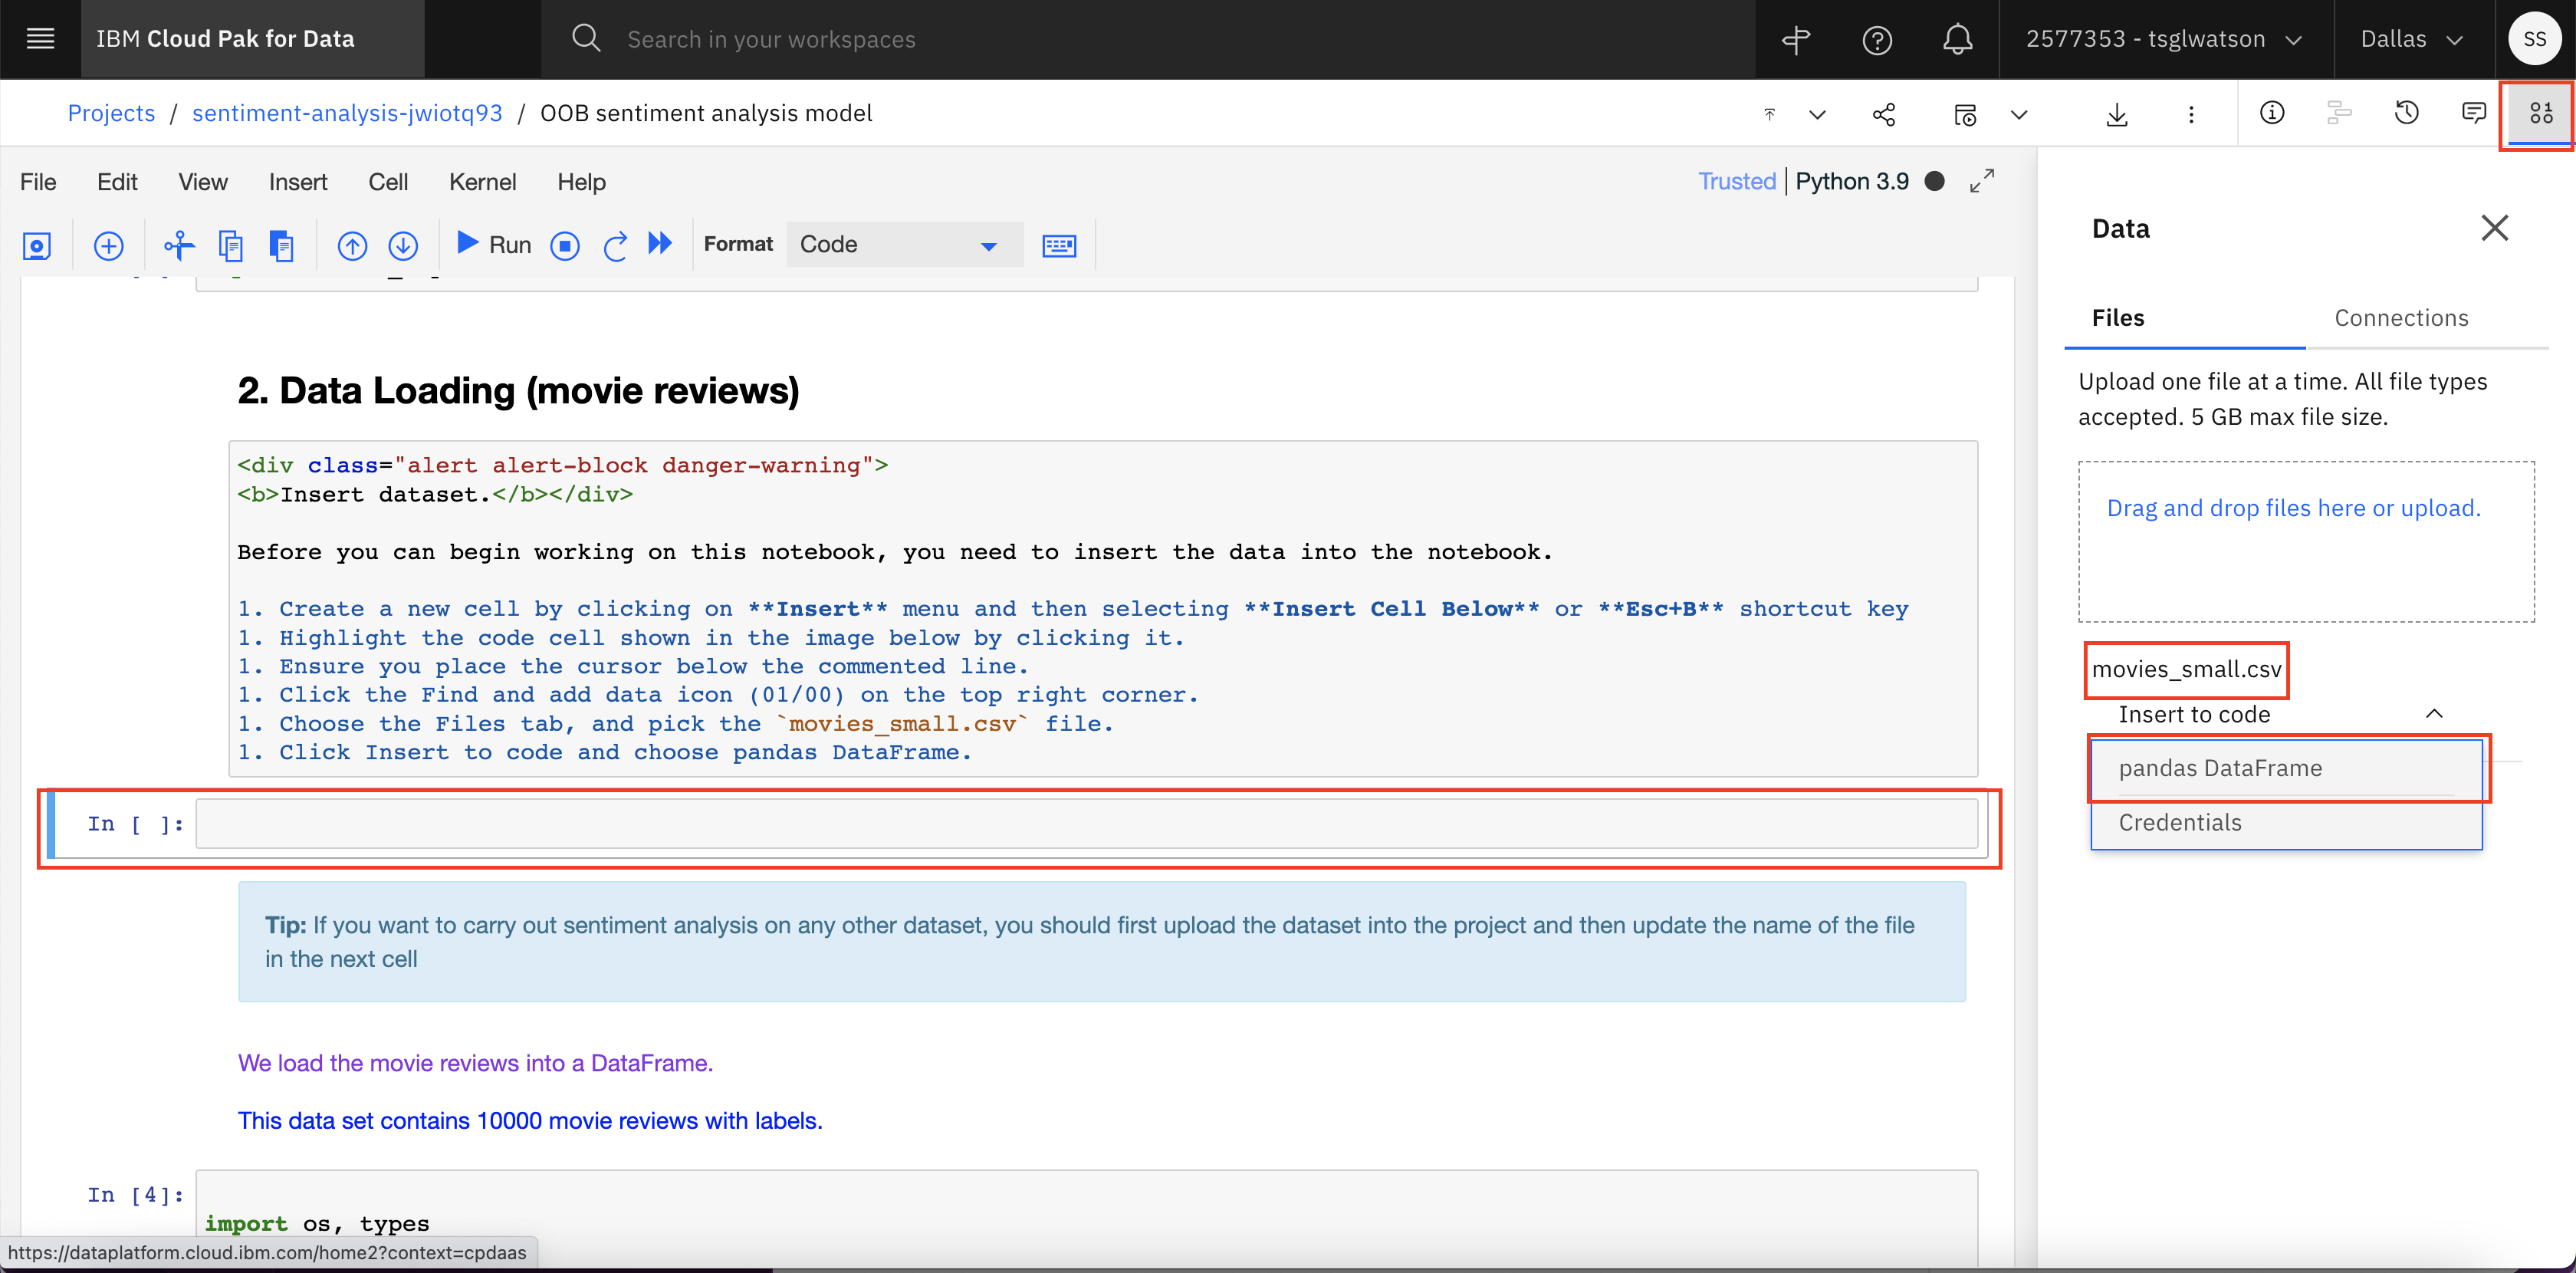


<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out sentiment analysis on any other dataset, you should first upload the dataset into the project and then update the name of the file in the next cell</div>

We load the movie reviews into a DataFrame.

This data set contains 10000 movie reviews with labels.

<a id="processData"></a>
## 3. Data Processing

Helper function to convert the raw data into processed data which can be fed into the sentiment classification model.

In [6]:
def convertToList(x):
    return [x]

In [7]:
def input_data_prep(df):
    df['weight'] = 1
    df.rename(columns={'label': 'labels'}, inplace=True)
    df = df[['text', 'weight', 'labels']]
    df['labels'] = df['labels'].replace({0: 'negative', 1: 'positive'})
#     df['labels'] = df['labels'].str.split(',')
    df['labels'] = df['labels'].apply(convertToList)
    display(df.head(5))
    return df

In [8]:
movies_df_processed = input_data_prep(movies_df)


,text,weight,labels
0,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The onl...",1,[negative]
1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some...",1,[negative]
2,Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you've got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and wh...,1,[negative]
3,"Even though I have great interest in Biblical movies, I was bored to death every minute of the movie. Everything is bad. The movie is too long, the acting is most of the time a Joke and the script is horrible. I did not get the point in mixing the story about Abraham and Noah together. So if you value your time and sanity stay away from this horror.",1,[negative]
4,"Im a die hard Dads Army fan and nothing will ever change that. I got all the tapes, DVD's and audiobooks and every time i watch/listen to them its brand new. <br /><br />The film. The film is a re run of certain episodes, Man and the hour, Enemy within the gates, Battle School and numerous others with a different edge. Introduction of a new General instead of Captain Square was a brilliant mov...",1,[positive]


Splitting the dataset into test & train. Train dataset will be used to train the sentiment classification model and test dataset will be used to evaluate the model.

In [9]:
from sklearn.model_selection import train_test_split
train_orig, test_orig = train_test_split(movies_df, test_size=0.2)
train, test = train_test_split(movies_df_processed, test_size=0.2)

In [10]:
train_file = './train_data.json'
train.to_json(train_file, orient='records')
    
test_file = './test_data.json'
test.to_json(test_file, orient='records')

test.head(2)

,text,weight,labels
8767,I've seen this movie on several different occasions. I find one of the funniest things to do is to just watch the reactions of the different types of people who go to see it.<br /><br />Type 1: OLD PEOPLE. A lot of old Japanese men and women go to this movie because they think it will be a honest-to-goodness samurai movie with lots of swordplay and medieval Japanese dialogue. As soon the two p...,1,[positive]
3428,"When I first saw this film it was not an impressive one. Now that I have seen it again with some friends on DVD ( they had not viewed it on the silver screen ), my opinion remains the same. The subject matter is puerile and the performances are weak.",1,[negative]


<a id="buildModel"></a>
## 4. Model Building

<a id="trainWorkflow"></a>
## 4.A Train the sentiment analysis model using workflow

In [11]:
import os
from watson_nlp.workflows.document_sentiment import BERT
from watson_nlp.toolkit import bert_utils

In [12]:
# Download Pretrained model resource 
pretrained_model_resource = watson_nlp.load(watson_nlp.download("pretrained-model_bert_multi_bert_multi_uncased"))
# Print the number of hidden layers
bert_config = bert_utils.BertConfig.from_json_file(pretrained_model_resource.bert_config_path)
print("num_hidden_layers in base model: {}".format(bert_config.num_hidden_layers))

num_hidden_layers in base model: 12


There are 12 layers in the `pretrained-model_bert_multi_bert_multi_uncased` model. You can modify the number of layers and other hyperparameters as shown in the next cells

In [13]:
# Download relevant stock models
print('Downloading Syntax')
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))

In [14]:
syntax_lang_code_map = {"en": syntax_model}

<div class="alert alert-block alert-warning">
<b>Warning!</b></div>
<span style="color:red">The next cell is going to take a lot of time in training. You can reduce this argument `train_max_seq_length` to 32 or 64 for quicker training</span>

#### Training hyperparameters & arguments:

- train_file: Name of the json file which will be used for training the model
- test_file: Name of the json file which will be used for evaluating the model
- syntax_lang_code_map: A dictionary with language and syntax model. `{"en": syntax_model}` in this case
- pretrained_model_resource: The name of the pretrained model downloaded from Watson NLP library. `pretrained-model_bert_multi_bert_multi_uncased` in this case.
- label_list: List of labels for sentiment classification. `['negative', 'neutral', 'positive']`
- learning_rate: [Learning rate for the model](https://en.wikipedia.org/wiki/Learning_rate). `2e-5`
- num_train_epochs: Number of times the learning algorithm will work through the entire training dataset. `5`
- do_lower_case: Convert all text to lower case. `True`
- train_max_seq_length: Maximum number of tokens that a training sequence can contain. `128`
- train_batch_size: Training batch size. `32`
- dev_batch_size: Validation batch size. `32`
- predict_batch_size: Test batch size. `128`
- predict_max_seq_length: Maximum number of tokens that a prediction sequence can contain. `64`
- num_layers_to_remove: Number of layers to be removed from the base model. `2`
- combine_approach: "Mean" will average score calculation directly while 'NON_NEUTRAL_MEAN' will ignore neutral sentences for average score calculation. `NON_NEUTRAL_MEAN`
- keep_model_artifacts: Keep model artifacts. `True`

In [15]:
# Train using the workflow with compression 
# Set number of layers to remove as 2
bert_wkflow = BERT.train(
              train_file,
              test_file,
              syntax_lang_code_map,
              pretrained_model_resource,
              label_list=['negative', 'neutral', 'positive'],
              learning_rate=2e-5,
              num_train_epochs=5,
              do_lower_case=True,
              train_max_seq_length=128,
              train_batch_size=32,
              dev_batch_size=32,
              predict_batch_size=128,
              predict_max_seq_length=128,
              num_layers_to_remove=2,
              combine_approach="NON_NEUTRAL_MEAN",
              keep_model_artifacts=True)

Epoch 1/5
250/250 - 9830s - loss: 17.1058 - test_accuracy: 0.7315 - val_loss: 10.7383 - val_test_accuracy: 0.8596 - 9830s/epoch - 39s/step
Epoch 2/5
250/250 - 9798s - loss: 7.8892 - test_accuracy: 0.9055 - val_loss: 9.9122 - val_test_accuracy: 0.8844 - 9798s/epoch - 39s/step
Epoch 3/5
250/250 - 9787s - loss: 4.9006 - test_accuracy: 0.9486 - val_loss: 10.9308 - val_test_accuracy: 0.9107 - 9787s/epoch - 39s/step
Epoch 4/5
250/250 - 9782s - loss: 2.9824 - test_accuracy: 0.9725 - val_loss: 14.7547 - val_test_accuracy: 0.9048 - 9782s/epoch - 39s/step
Epoch 5/5
250/250 - 9778s - loss: 2.1926 - test_accuracy: 0.9840 - val_loss: 17.0539 - val_test_accuracy: 0.9038 - 9778s/epoch - 39s/step


./build/lib/watson_nlp/blocks/document_sentiment/bert/bert.py:456: DeprecationWarning: Call to deprecated class BERT. (BERT Document Sentiment Class is deprecated. Please use watson_nlp.blocks.sentiment.sentence_sentiment_bert.SentenceSentimentBERT instead.) -- Deprecated since version 3.X.X.
./build/lib/watson_nlp/workflows/document_sentiment/bert.py:385: DeprecationWarning: Call to deprecated class BERT. (BERT Document Sentiment Workflow is deprecated. Please use watson_nlp.workflows.sentiment.aggregated_workflow.AggregatedSentiment instead.) -- Deprecated since version 3.X.X.


In [16]:
# BERT config has been updated and saved in pre_train artifacts"
bert_updated_config_path = "bert_pretrain_artifact/bert_config.json"
bert_config_updated  = bert_utils.BertConfig.from_json_file(bert_updated_config_path)
print("num_hidden_layers after compression: {}".format(bert_config_updated.num_hidden_layers))

num_hidden_layers after compression: 10


You can observe here that the number of layers after compression has reduced from 12 to 10 i.e 2 layers were reduced from the base model for faster training.

<a id="saveModel"></a>
## 4.B Save the workflow/model

In [17]:
# Save the Workflow in a given location
model_path = 'bert_set/wkflow'
bert_wkflow.save('bert_set/wkflow')

In [18]:
# Load the saved workflow for predict
wk_loaded = watson_nlp.load(model_path)

./build/lib/watson_nlp/blocks/document_sentiment/bert/bert.py:162: DeprecationWarning: Call to deprecated class BERT. (BERT Document Sentiment Class is deprecated. Please use watson_nlp.blocks.sentiment.sentence_sentiment_bert.SentenceSentimentBERT instead.) -- Deprecated since version 3.X.X.
./build/lib/watson_nlp/workflows/document_sentiment/bert.py:216: DeprecationWarning: Call to deprecated class BERT. (BERT Document Sentiment Workflow is deprecated. Please use watson_nlp.workflows.sentiment.aggregated_workflow.AggregatedSentiment instead.) -- Deprecated since version 3.X.X.


In [19]:
# Run the workflow with input as raw document and language code
raw_document = 'I have been looking for this film for ages because it is quite rare to find as it was one of the video nasties. I finally found it on DVD at the end of last year it is a very low budget movie The story is set around amazon jungle tribes that are living in fear of the devil. Laura Crawford is a model who is kidnapped by a gang of thugs while she is working in South America. They take her into the jungle Laura is guarded by some ridiculous native who calls himself "The Devil" she has to go though all unpleasant things until they are happy. Maidens are Chained up. The devil demonstrates eating flesh in a horrible manner. Peter Weston, is the devil hunter, who goes into the jungle to try and rescue her,'
sentiment = wk_loaded.run(raw_document, language_code="en")
sentiment

{
  "score": 0.364364,
  "label": "SENT_POSITIVE",
  "mixed": true,
  "target": "",
  "sentiment_mentions": [],
  "producer_id": {
    "name": "Document BERT Sentiment",
    "version": "0.0.1"
  }
}

Save the model on the Cloud Object Storage (COS) associated with the Watson Studio instance

In [20]:
#project.save_data('bert_wkflow_imdb_5_epochs', data=bert_wkflow.as_file_like_object(), overwrite=True)

<a id="evaluateModel"></a>
## 5. Model Evaluation

Helper functions to extract text from the dataset and create a new dataframe with the corresponding sentiment

In [21]:
def extract_sentiment(review_text):
    # run the syntax model
    syntax_result = syntax_model.run(review_text, parsers=('token', 'lemma', 'part_of_speech'))
    sentiment_result = wk_loaded.run(review_text, sentence_sentiment=True, language_code="en")
    
    document_sentiment = sentiment_result.to_dict()['label']
    return document_sentiment

# Helper method to create a new dataframe with the corresponding sentiment
def create_sentiment_dataframe(df):
    sentiment = df['text'].apply(lambda text: extract_sentiment(text))
    sentiment_df = pd.DataFrame()
    sentiment_df['Document Sentiment'] = sentiment
    return sentiment_df

In [22]:
test_small = test_orig

In [23]:
sentiment_df = create_sentiment_dataframe(test_small)
movies_sentiment_df = test_small[['text', 'labels']].merge(sentiment_df[['Document Sentiment']], how='left', left_index=True, right_index=True)
movies_sentiment_df.head()

,text,labels,Document Sentiment
2828,"This film has nothing whatever to do with the Sphinx, and the title is just a come-on. The story concerns an imagined true and concealed tomb in the Valley of the Kings, of King Seti I, second pharaoh of the 19th Dynasty, New Kingdom period. It is not a bad yarn, and a great deal of the film is shot on location. Even the scenes in the Winter Palace Hotel lobby in Luxor were really shot there, ...",0,SENT_NEGATIVE
8360,"I went to see this movie at our college theater thirty years ago because I liked Bruce Dern in Silent Running and Family Plot. To this day (sorry Jack Nicholson), it is still the dullest movie I've ever seen. It just went on and on with no discernible point and then - it just ended. The lights came up and I watched everyone looking around in confusion. Had the projectionist missed a reel? I've...",0,SENT_NEGATIVE
3369,"Whether this movie is propaganda or not (I firmly believe it is not), it really shows the power of Media. The importance of this documentary is not to show how good of a man Chavez is. It is really to demonstrate the way the Bolivarians saw how it happened, the Chavez way of seeing it. Although it may seem wrong and bias to support a film , I think the point of view shown in the movie is utter...",1,SENT_POSITIVE
4821,"Larry Clark is not renowned for his talents as a writer or a director, but he has made some undeniably important films. Kids, Bully, and to a lesser extent Ken Park all achieve their intended purpose: shock, revulsion, and even disgust. These films are uncompromising in their content and use their controversial nature to expose very serious problems in modern youth. Kids exposed us to the prol...",0,SENT_NEGATIVE
9840,"I just saw DreamGirls yesterday, and I was REALLY underimpressed. Despite all the Oscar buzz, this is nothing special. Anyone who was really impressed by this film has never bothered to see any of the true movie musical classics. Except for Eddie Murphy's great musical and dramatic performance, Dreamgirls is just a glorified TV movie with no style or flair. Just a bunch of amateurs singing AT ...",0,SENT_NEGATIVE


Using custom function to calculate accuracy. **Note**: model evaluation method is WIP for the workflow based model and will be released soon after which you will not need to write custom code for evaluation.

In [24]:
import numpy as np
conditions = [
    movies_sentiment_df['labels'].eq(0) & movies_sentiment_df['Document Sentiment'].eq('SENT_NEGATIVE'),
    movies_sentiment_df['labels'].eq(1) & movies_sentiment_df['Document Sentiment'].eq('SENT_POSITIVE'),
]

choices = [1,1]

movies_sentiment_df['score'] = np.select(conditions, choices, default=0)

In [25]:
print("ACCURACY SCORE:", movies_sentiment_df['score'].sum()/len(movies_sentiment_df['score']))

ACCURACY SCORE: 0.8855


### Confusion Matrix

In [26]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# actual values
movies_sentiment_df['labels'] = movies_sentiment_df['labels'].replace({0:'SENT_NEGATIVE', 1:'SENT_POSITIVE'})
actual = movies_sentiment_df['labels']
# predicted values
predicted = movies_sentiment_df['Document Sentiment']

# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=['SENT_POSITIVE','SENT_NEGATIVE'])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=['SENT_POSITIVE','SENT_NEGATIVE']).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=['SENT_POSITIVE','SENT_NEGATIVE'])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[837 167]
 [ 62 934]]
Outcome values : 
 837 167 62 934
Classification report : 
                precision    recall  f1-score   support

SENT_POSITIVE       0.93      0.83      0.88      1004
SENT_NEGATIVE       0.85      0.94      0.89       996

     accuracy                           0.89      2000
    macro avg       0.89      0.89      0.89      2000
 weighted avg       0.89      0.89      0.89      2000



<a id="summary"></a>
## 6. Summary

<span style="color:blue">This notebook demonstrates how to fine-tune/re-train the BERT Sentiment workflow using compression. The model performance has improved over Out-of-the-box (OOTB) pre-trained model where accuracy was 87% and which is now 96% with the fine-tuned model. The model performance generally improves especially if you have nuances in the dataset that your model needs to learn from the dataset.</span>



Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the hosting [GitHub repository](https://github.com/ibm-build-labs/Watson-NLP). 

Developed by IBM Build Lab 

Copyright - 2022 IBM Corporation